In [79]:
import cv2
import cvzone
import numpy as np
import matplotlib.pyplot as plt

ground_color = None

img = cv2.imread("test2.webp")
if ground_color is None:
    ground_color = img[int(img.shape[0]/2) ,int(img.shape[1]/2)]
img_contours = img.copy()
dh, dw, _ = img.shape



49.70572916666667
79.0


(array([2.800e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

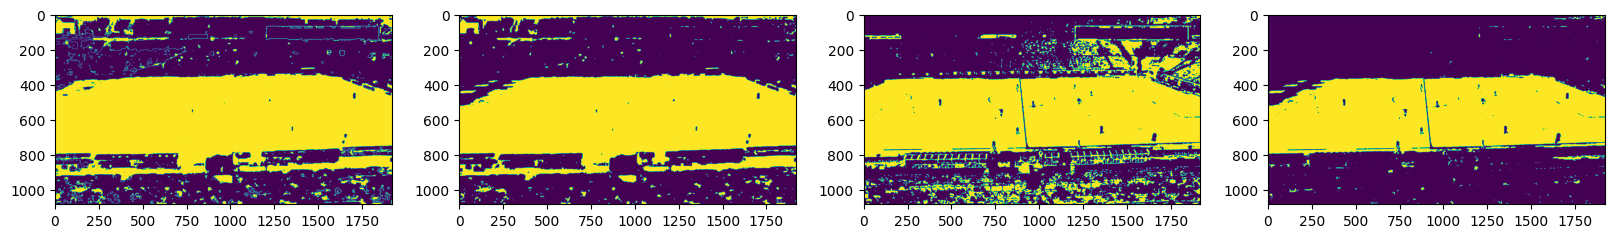

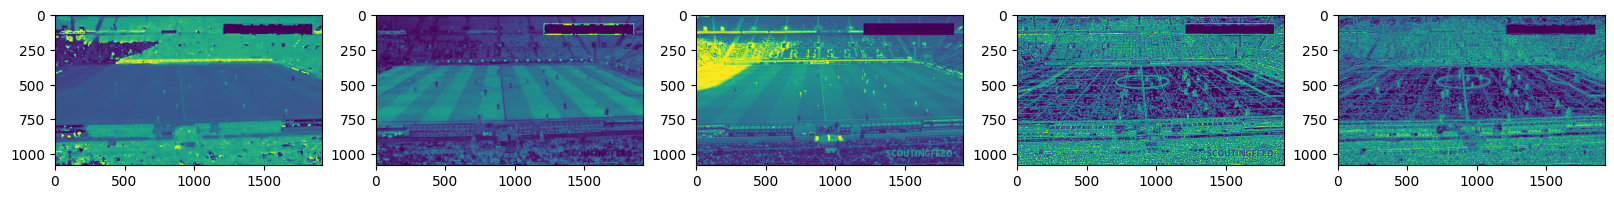

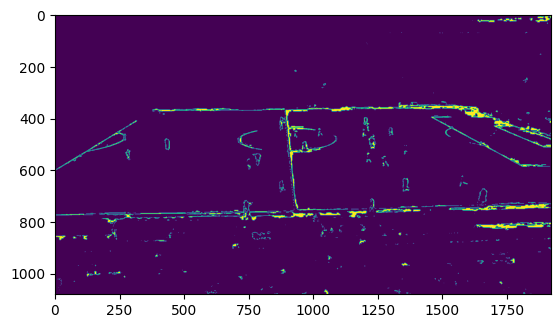

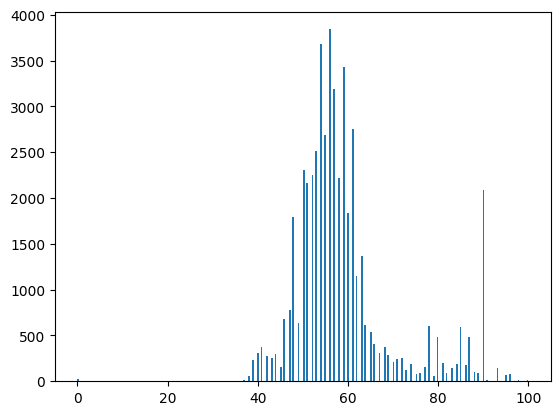

In [116]:

#converting into hsv image
hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#hue histogram
#plt.hist(hsv[:,:,0].flatten(),bins=256)

#h_l,h_h = np.percentile(hsv[:,:,0],[20,80])
h_l,h_h = (40,90) # <- hand pick green partition of hsv
s_l,s_h = np.percentile(hsv[:,:,1],[10,90])
v_l,v_h = np.percentile(hsv[:,:,2],[5,95])

#green range
lower_green = np.array([h_l,s_l,v_l])
upper_green = np.array([h_h,s_h,v_h])

# define the base green mask
#mask = cv2.inRange(hsv, lower_green, upper_green) <-- full hsv thresholding is not good
mask = cv2.inRange(cv2.blur(hsv[:,:,0],(3,3)),35,95) # <-- rough green segmentation

#easy(er) mask handling
m_data = np.ma.masked_array(hsv[:,:,0],mask=mask==0)

# find outliers
rng = np.percentile(m_data.compressed(),[5,95]) 
# remove outlier green values
improved_green = cv2.medianBlur((cv2.inRange(hsv[:,:,0],*rng)),5)
est_non_filed_percentage = (1 - m_data.count()/hsv[:,:,0].size)*100
print(est_non_filed_percentage)

# field tends to have very high saturation compared to other parts of the arena
high_sat = cv2.medianBlur((cv2.inRange(hsv[:,:,1],np.percentile(hsv[:,:,1],est_non_filed_percentage),256)),5)
#combine
field_mask_base = cv2.bitwise_and(improved_green,high_sat)

#visuals
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(mask)
plt.subplot(142)
plt.imshow(improved_green)
plt.subplot(143)
plt.imshow(high_sat)
plt.subplot(144)
plt.imshow(field_mask_base)

#ligth saturation may be change the hue, it can be detected with selecting high value pixels
hue_may_saturated =  cv2.inRange(hsv[:,:,2],220,255)

median_mask_conv = mask
for i in range(5):
    median_mask_conv = cv2.medianBlur(median_mask_conv,11)

wlines = cv2.inRange(hsv[:,:,1],0,np.percentile(hsv[:,:,1],est_non_filed_percentage))

plt.figure(figsize=(20,5))
plt.subplot(151)
plt.imshow(hsv[:,:,0])
plt.subplot(152)
plt.imshow(hsv[:,:,1])
plt.subplot(153)
plt.imshow(hsv[:,:,2])
plt.subplot(154)
plt.imshow(hsv[:,:,2]- cv2.GaussianBlur(hsv[:,:,2],(11,11),sigmaX=0))
plt.subplot(155)
plt.imshow(hsv[:,:,1]-cv2.blur(hsv[:,:,1],(3,3)))

plt.figure()
#plt.hist(hsv[:,:,1].flatten(),bins=255)
#"high pass filter"
hpass = cv2.blur(hsv[:,:,1]-cv2.blur(hsv[:,:,1],(3,3)),(5,5))
#plt.imshow(cv2.bitwise_and(hpass,field_mask_base))

dil_field = cv2.dilate(field_mask_base,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)))
field_masked = np.ma.masked_array(hsv[:,:,1],dil_field == 0)

low_sat_trs = np.percentile(field_masked.compressed(),15)
print(low_sat_trs)

line_suspect_mask = cv2.bitwise_and(field_mask_base,cv2.inRange(hsv[:,:,1],0,low_sat_trs))
plt.imshow(line_suspect_mask)
plt.figure()
line_m = np.ma.masked_array(hsv[:,:,0],line_suspect_mask == 0)
plt.hist(line_m.compressed(),bins=256)

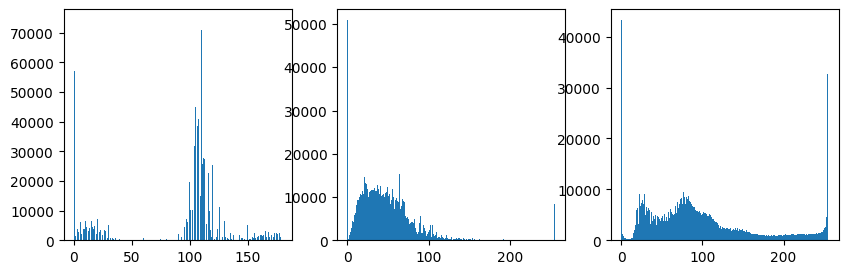

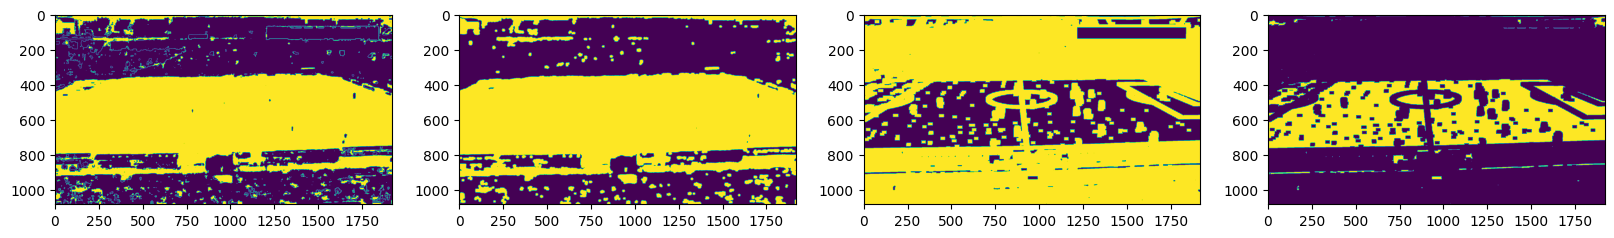

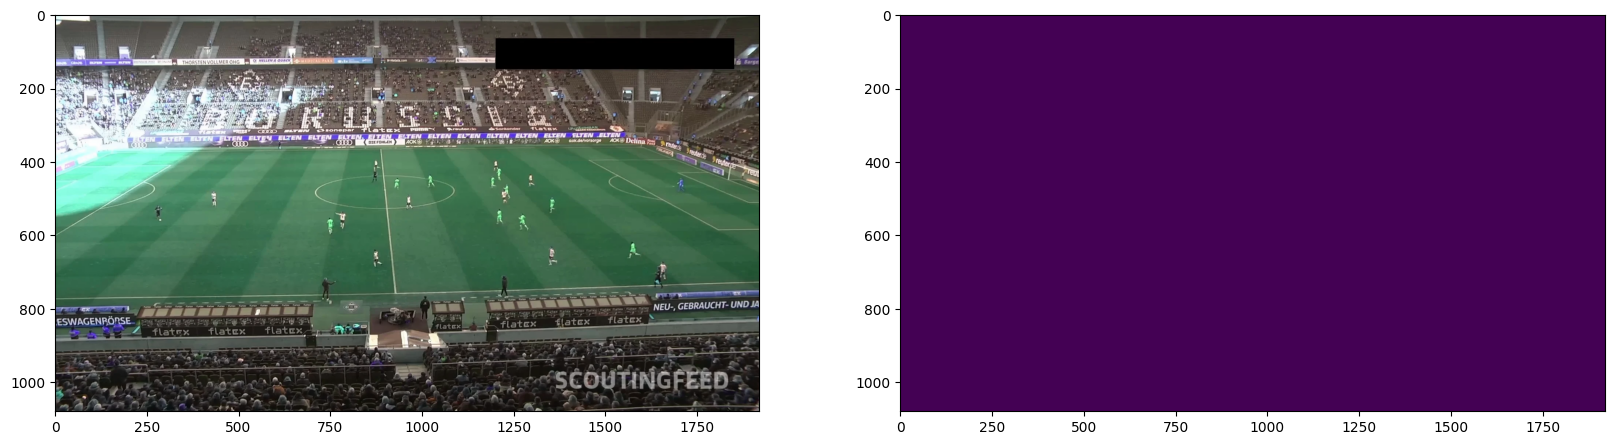

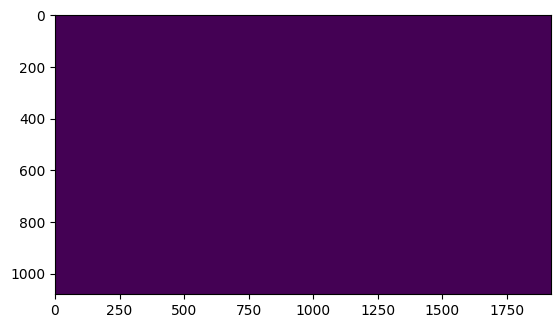

In [97]:

# define edge avare mask
adt_mask = cv2.adaptiveThreshold(gray,255,adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,thresholdType=cv2.THRESH_BINARY,blockSize=11,C=5)
# define edge avare inverted
adt_mask_inv  = cv2.bitwise_not(adt_mask)
# create viewer mask -> based on high frequency components of the mask, blurring the edge avera mask can generate a "noise" density map
avg_noise = cv2.blur(adt_mask_inv,(25,17))
viewer_mask = cv2.inRange(avg_noise,np.percentile(avg_noise,20)+1,255)
#viewer_mask = cv2.erode(viewer_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,17)))
#remove holes
#viewer_mask = cv2.erode(viewer_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(31,31)))
#under estimate mask size
#viewer_mask = cv2.dilate(viewer_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(21,21)))

#compensate gaussian kernel
viewer_mask_inv = cv2.bitwise_not(viewer_mask)



#remove noise from the green mask
eroded_mask = cv2.erode(mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,5)))
#remove holes from the green mask based on morphologies
main_morph_mask = cv2.dilate(eroded_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15)))

#remove viewers from morph mask
field_mask = cv2.bitwise_and(mask,viewer_mask_inv)

#extend mask
main_morph_mask_ext = cv2.dilate(eroded_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(21,21)))
plt.figure(figsize=(10,3))
for i in range(3):
    masked_data = np.ma.masked_array(hsv[:,:,i],mask=main_morph_mask_ext)
    plt.subplot(131 + i)
    plt.hist(masked_data.compressed(),bins=255)

#visuals
plt.figure(figsize=(20,3))
plt.subplot(141)
plt.imshow(mask)
plt.subplot(142)
plt.imshow(main_morph_mask)
plt.subplot(143)
plt.imshow(viewer_mask)
plt.subplot(144)
plt.imshow(field_mask)

#mask lines on the filed with the green mask == white lines on the footballfield, and players
composite_mask = cv2.bitwise_and(field_mask,adt_mask_inv)

#make the lines non edges
dilated_comp_mask = cv2.dilate(composite_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))
composite_mask = cv2.erode(dilated_comp_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))

#visuals
plt.figure( figsize=(20,10))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(composite_mask)

res = cv2.bitwise_and(img, img, mask=composite_mask)
res_bgr = cv2.cvtColor(res,cv2.COLOR_HSV2BGR)
plt.figure()
plt.imshow(res)
img_blur = cv2.medianBlur(res_bgr ,5)
img_gray = cv2.cvtColor(img_blur ,cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray)


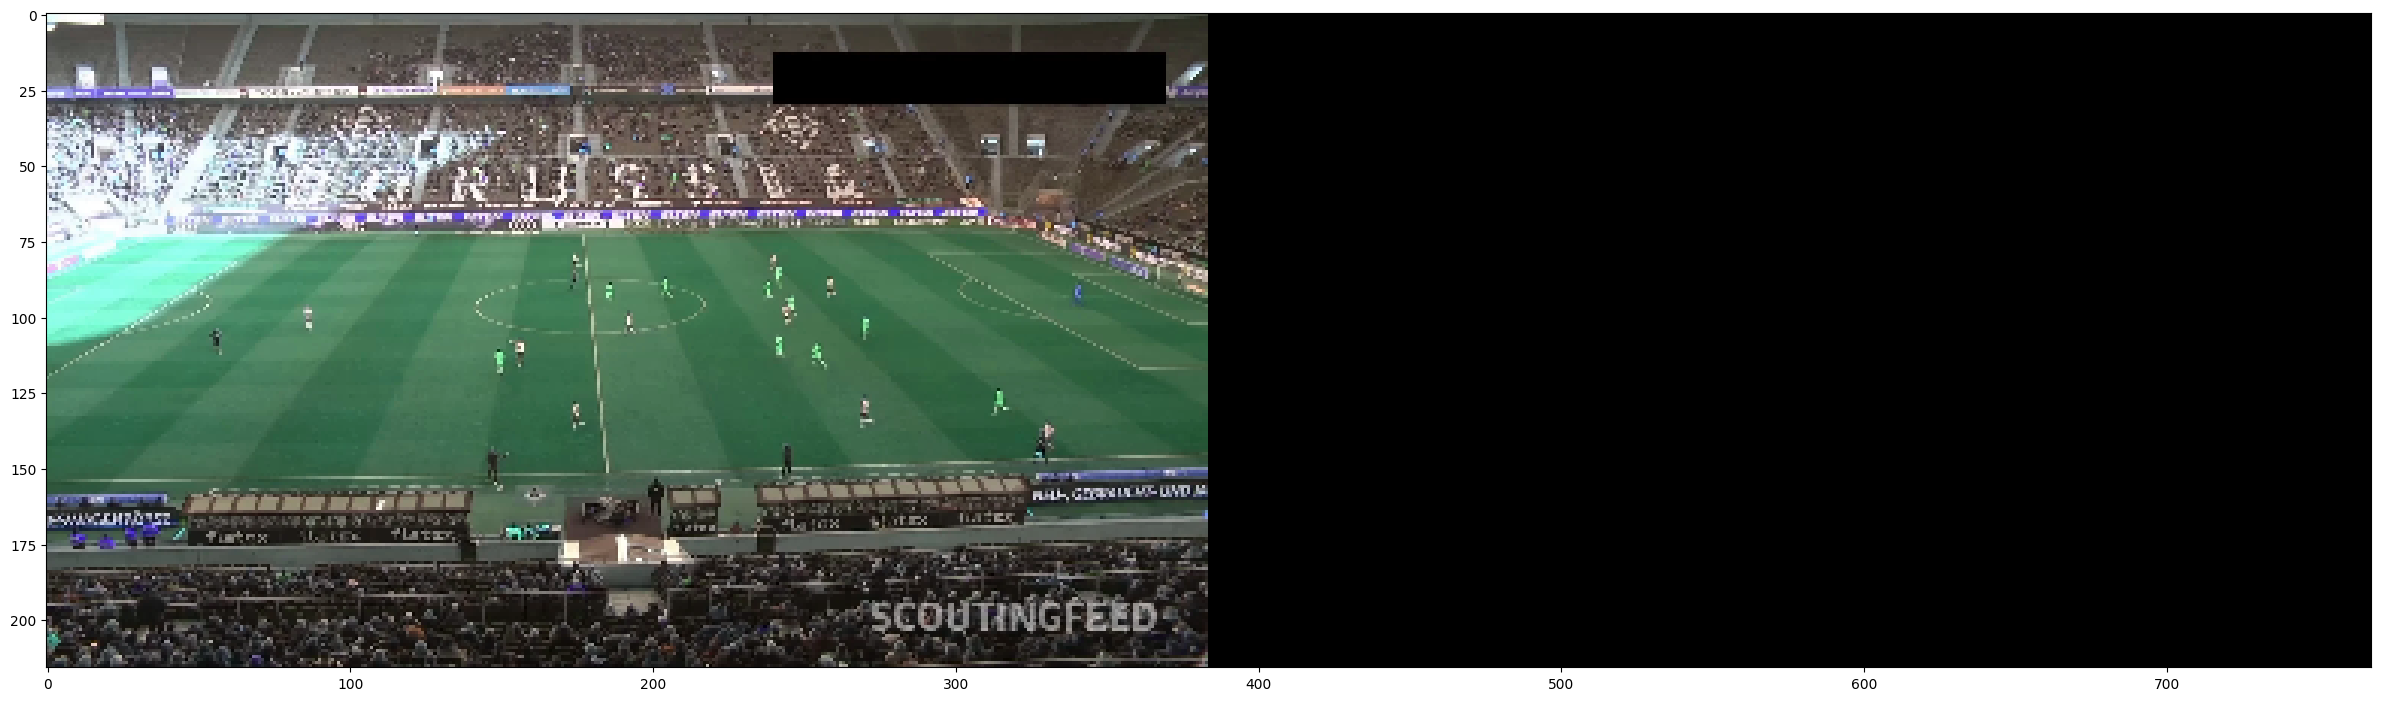

In [98]:
#threshold1 = cv2.getTrackbarPos("threshold1","Parameters")
# threshold2 = cv2.getTrackbarPos("threshold2","Parameters")
v = np.median(img_gray)
sigma = 0.33
#---- apply optimal Canny edge detection using the computed median----
lower_thresh = int(max(0, (1.0 - sigma) * v))
upper_thresh = int(min(255, (1.0 + sigma) * v))
# print(threshold1,threshold2)

img_canny = cv2.Canny(img_gray,lower_thresh,upper_thresh)

img_stack = cvzone.stackImages(([img,img_canny]) ,2,0.2)

plt.figure(figsize=(30,10))
plt.imshow(img_stack)